##### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [4]:
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.keys())

['/us_equities/stocks', '/stooq/us/nyse/stocks/prices', '/stooq/us/nyse/stocks/tickers', '/stooq/us/nyse/etfs/prices', '/stooq/us/nyse/etfs/tickers', '/stooq/us/nasdaq/stocks/prices', '/stooq/us/nasdaq/stocks/tickers', '/stooq/us/nasdaq/etfs/prices', '/stooq/us/nasdaq/etfs/tickers', '/sp500/fred_price', '/sp500/stocks_name', '/factors/apha_101', '/factors/common', '/data/top500_dataset', '/data/top500_dataset_with_TA', '/data/top500_dataset_with_rolling_beta_size_proxy']


In [6]:
with pd.HDFStore(DATA_STORE) as store:
    nyse_stocks = store['/stooq/us/nyse/stocks/prices']
    nasdaq_stocks = store['/stooq/us/nasdaq/stocks/prices']
    metadata = store['us_equities/stocks'].loc[:, ['market cap', 'sector']]

In [7]:
# Concatenate the two DataFrames
data = pd.concat([nyse_stocks, nasdaq_stocks])

# Drop NaN values and duplicates
data = data.dropna().drop_duplicates()

# Display the cleaned DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11958377 entries, ('', Timestamp('2013-01-02 00:00:00')) to ('ZYXI', Timestamp('2023-08-11 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 502.2+ MB
None


In [8]:
metadata.sector = pd.factorize(metadata.sector)[0]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7516 entries, AACG to ZWS
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   market cap  7078 non-null   float64
 1   sector      7516 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 176.2+ KB


In [9]:
metadata

,market cap,sector
ticker,,
AACG,4.079576e+07,0
AACI,0.000000e+00,1
AACIW,0.000000e+00,1
AADI,1.449124e+08,2
AAL,1.022514e+10,0
...,...,...
ZTR,0.000000e+00,1
ZTS,8.818486e+10,2
ZUO,1.433740e+09,3


In [10]:
data = data.join(metadata).dropna(subset=['sector'])


In [11]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 6,700 | # Dates: 2,671


In [12]:
# Identifying duplicate entries based on index
duplicates = data[data.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [open, high, low, close, volume, market cap, sector]
Index: []


##### Select 500 most-traded stocks

In [13]:
dv = data.close.mul(data.volume)
dv = dv[~dv.index.duplicated(keep='first')]

In [14]:
top500 = (dv.groupby(level='date')
          .rank(ascending=False)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .nsmallest(500))

##### Visualize the 200 most liquid stocks

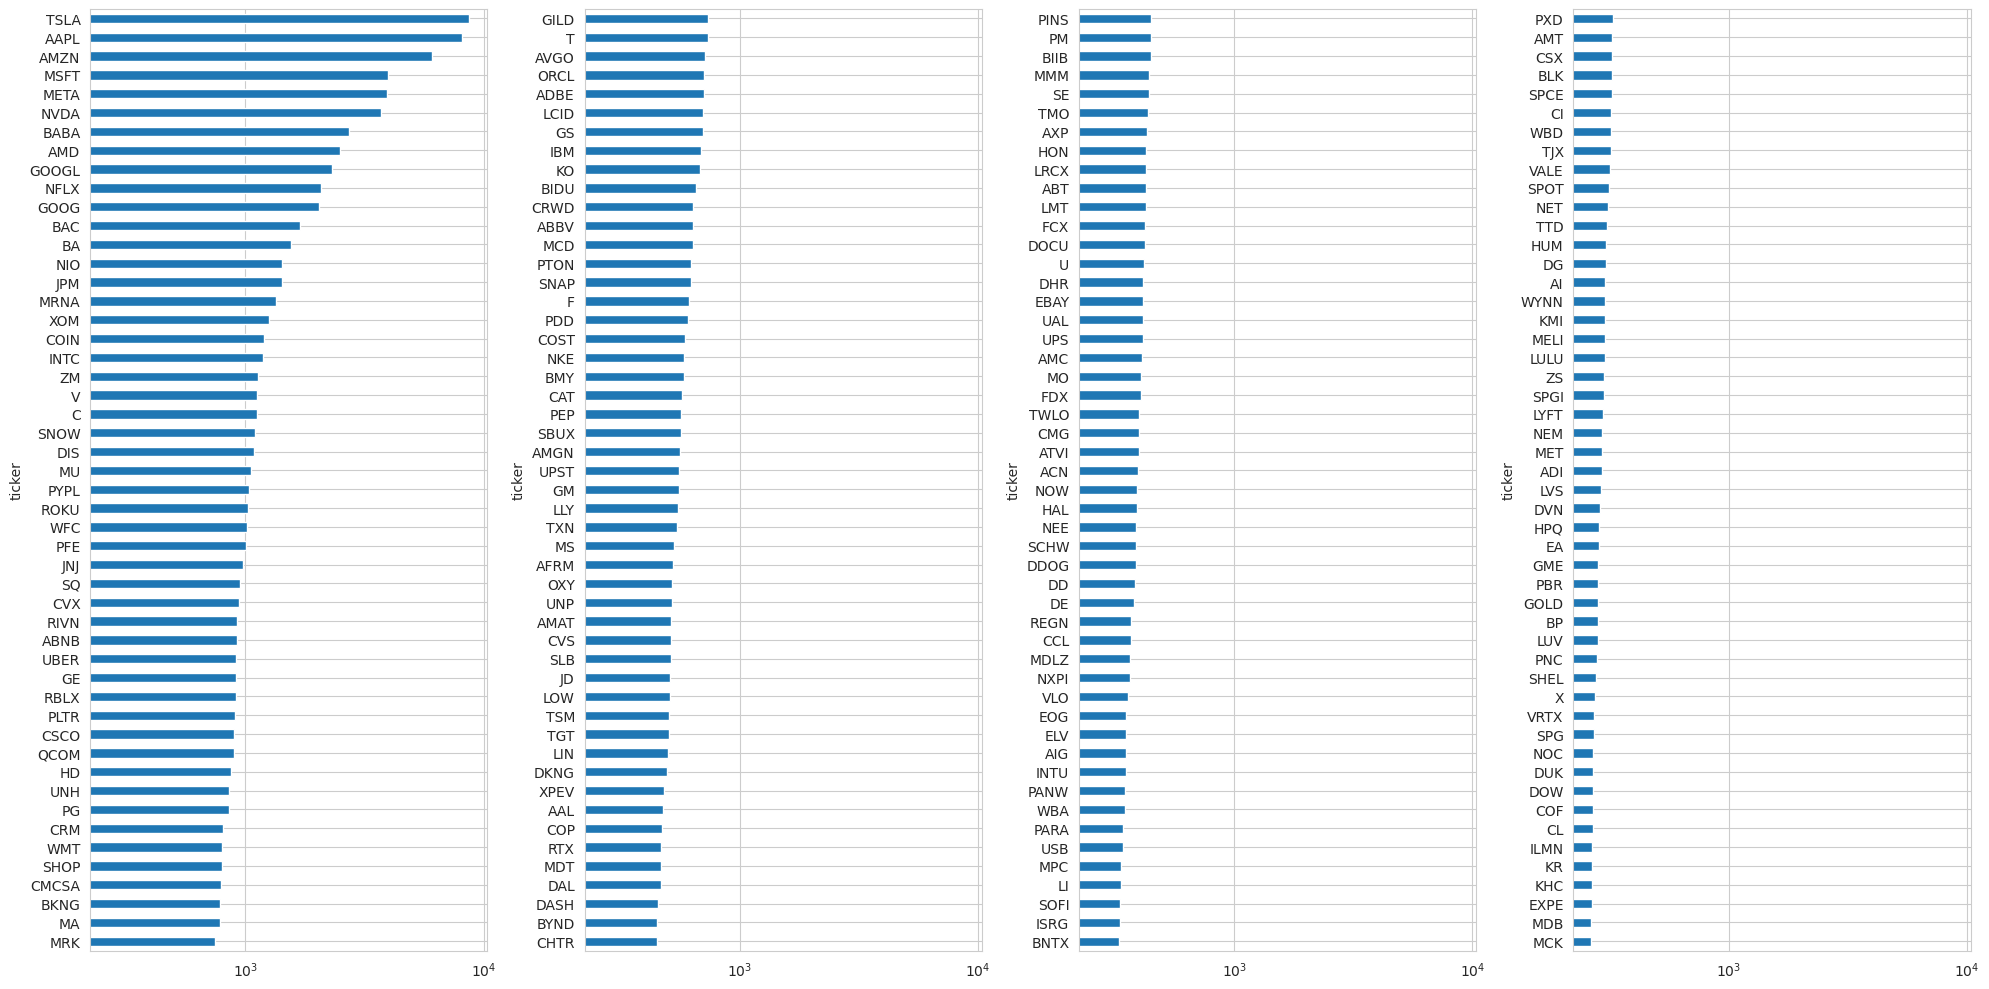

In [15]:
dv = data.close.mul(data.volume).div(1e6)  # scaling values to millions
dv = dv[~dv.index.duplicated(keep='first')]

# Group by date and ticker, then by ticker alone
avg_dv_per_ticker = dv.groupby(level=['date', 'ticker']).mean().groupby(level='ticker').mean()

# Get top 200 tickers based on the average dollar volume
top200_tickers = avg_dv_per_ticker.nlargest(200)

cutoffs = [0, 50, 100, 150, 200]
fig, axes = plt.subplots(ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, cutoff in enumerate(cutoffs[1:], 1):
    top200_tickers.iloc[cutoffs[i-1]:cutoffs[i]].sort_values().plot.barh(logx=True, ax=axes[i-1])

fig.tight_layout()

In [16]:
to_drop = data.index.unique('ticker').difference(top500.index)

In [17]:
len(to_drop)

6200

In [18]:
data = data.drop(to_drop, level='ticker')

In [19]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1339760 entries, ('AA', Timestamp('2013-01-02 00:00:00')) to ('ZION', Timestamp('2023-08-11 00:00:00'))
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        1339760 non-null  float64
 1   high        1339760 non-null  float64
 2   low         1339760 non-null  float64
 3   close       1339760 non-null  float64
 4   volume      1339760 non-null  float64
 5   market cap  1339760 non-null  float64
 6   sector      1339760 non-null  float64
dtypes: float64(7)
memory usage: 77.1+ MB


In [20]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,671


##### Remove outlier observations based on daily returns

In [21]:
before = len(data)
data['ret'] = data.groupby('ticker').close.pct_change()
data = data[data.ret.between(-1, 1)].drop('ret', axis=1)
print(f'Dropped {before-len(data):,.0f}')

Dropped 2,933


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1336827 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZION', Timestamp('2023-08-11 00:00:00'))
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        1336827 non-null  float64
 1   high        1336827 non-null  float64
 2   low         1336827 non-null  float64
 3   close       1336827 non-null  float64
 4   volume      1336827 non-null  float64
 5   market cap  1336827 non-null  float64
 6   sector      1336827 non-null  float64
dtypes: float64(7)
memory usage: 76.9+ MB


In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df, ticker):
    # Extract relevant data for the ticker
    ticker_data = df.loc[ticker]
    
    # Ensure data covers at least 2 years, otherwise return a message
    if len(ticker_data) < 2 * 252:  # Assuming 252 trading days in a year
        return f"Insufficient data for {ticker}. Need at least 2 years of data."

    # Calculate log and percentage returns
    ticker_data['log_ret'] = np.log(ticker_data['close'] / ticker_data['close'].shift(1))
    ticker_data['pct_ret'] = ticker_data['close'].pct_change()

    # Drop NaN values (the first row after computing returns)
    ticker_data = ticker_data.dropna()

    # Test stationarity for each series using ADF
    adf_price = adfuller(ticker_data['close'])
    adf_log_ret = adfuller(ticker_data['log_ret'])
    adf_pct_ret = adfuller(ticker_data['pct_ret'])
    
    # Store results in a dictionary for comparison
    results = {
        'price': adf_price[0],
        'log_ret': adf_log_ret[0],
        'pct_ret': adf_pct_ret[0]
    }
    # Find which series is the most stationary based on the ADF statistic (the lower, the better)
    most_stationary = min(results, key=results.get)
    
    return most_stationary, results

# Example usage:
ticker = 'AAPL'  # Replace with desired ticker
most_stationary, results = test_stationarity(data, ticker)
print(f"For {ticker}, the most stationary series is: {most_stationary}.")
print("ADF Results:", results)

For AAPL, the most stationary series is: pct_ret.
ADF Results: {'price': 0.4633927548084181, 'log_ret': -16.492797724238496, 'pct_ret': -16.585440873113704}


In [25]:
tickers = data.index.unique('ticker')
print(f"# Tickers: {len(tickers):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,671


##### Compute returns
- Frac diff

In [26]:
import torch
from fracdiff.torch import fdiff

# Conventional returns calculation
T = [1, 2, 3, 4, 5, 10, 21, 42, 63, 126, 252]

by_ticker = data.groupby(level='ticker')

for t in T:
    data[f'ret_{t:02}d'] = by_ticker.close.pct_change(t)

# Fractional differentiations calculation
T_frac = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def compute_frac_diff(ticker_data, T_frac, window_size=10):
    close_prices = ticker_data['close'].values
    close_tensor = torch.tensor(close_prices).float()

    for t in T_frac:
        frac_diff_tensor = fdiff(close_tensor, t, window=window_size, mode="same")
        ticker_data[f'frac_diff_{t}'] = frac_diff_tensor.numpy()

    return ticker_data

# Apply the compute_frac_diff function to each group and concat the results
data_with_frac_diff_and_ret = pd.concat([compute_frac_diff(group, T_frac) for _, group in by_ticker])

ModuleNotFoundError: No module named 'fracdiff'

- Historical returns

In [ ]:
T = [1, 2, 3, 4, 5, 10, 21, 42, 63, 126, 252]

by_ticker = data.groupby(level='ticker')

for t in T:
    data[f'ret_{t:02}d'] = by_ticker.close.pct_change(t)

In [ ]:
data

##### Forward returns

In [ ]:
data['ret_fwd_01d'] = by_ticker.ret_01d.shift(-1)
data = data.dropna(subset=['ret_fwd_01d'])

In [ ]:
data

##### Persist results

In [ ]:
data.info(null_counts=True)

In [ ]:
data.to_hdf(DATA_STORE, 'data/top500_dataset')